In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_163.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_330.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_498.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_167.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_76.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_439.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_226.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_168.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_96.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_64.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_373.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_115.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_20.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_559.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/

In [2]:
# Cài đặt các thư viện cần thiết (nếu cần)
#!pip install torch torchvision matplotlib seaborn scikit-learn

# Import các thư viện
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import numpy as np

### 1. Tiền xử lý dữ liệu
Dataset được tổ chức thành 4 lớp: `Closed`, `Open`, `no_yawn`, `yawn`. Để huấn luyện mô hình:
- Áp dụng các biến đổi (transforms) như thay đổi kích thước ảnh về 224x224 (phù hợp với VGG16), chuẩn hóa giá trị pixel.
- Chia dữ liệu thành tập train và test bằng cách sử dụng cấu trúc thư mục có sẵn.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/yawn-eye-dataset-new/dataset_new'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

# Tính trọng số lớp (tăng trọng số cho lớp yawn)
targets = np.array(image_datasets['train'].targets)
class_counts = [sum(targets == i) for i in range(len(class_names))]
print(f"Class counts: {class_counts}")

Classes: ['Closed', 'Open', 'no_yawn', 'yawn']
Dataset sizes: {'train': 2467, 'test': 433}
Class counts: [617, 617, 616, 617]


In [5]:
class_weights = torch.FloatTensor([1.0, 1.0, 1.0, 1.5]).to(device)  # Tăng trọng số lớp yawn

### 2. Xây dựng mô hình VGG16
- Sử dụng VGG16 pre-trained từ `torchvision`.
- Thay đổi lớp fully connected cuối cùng để phù hợp với 4 lớp đầu ra: `Closed`, `Open`, `no_yawn`, `yawn`.
- Đóng băng các tầng convolution để giữ lại đặc trưng đã học, chỉ huấn luyện tầng fully connected.

In [6]:
# Tải mô hình VGG16 pre-trained
model = models.vgg16(pretrained=True)
# Fine-tune các tầng convolution cuối
for param in model.features[:28].parameters():
    param.requires_grad = False
for param in model.features[28:].parameters():
    param.requires_grad = True

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 4)
)
model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 236MB/s]


### 3. Huấn luyện mô hình
- Huấn luyện trên tập train với 10 epochs (có thể điều chỉnh).
- Sử dụng Adam optimizer với learning rate = 0.001.
- Lưu lại loss và accuracy cho từng epoch để trực quan hóa.

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    best_acc = 0.0
    best_model_path = '/kaggle/working/best_model.pth'
    trigger_times = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                test_losses.append(epoch_loss)
                test_accs.append(epoch_acc.item())
                scheduler.step()
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_path)
                    print(f'Saved best model with Test Acc: {best_acc:.4f}')
                    trigger_times = 0
                else:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print(f'Early stopping triggered after {epoch+1} epochs!')
                        return model, train_losses, test_losses, train_accs, test_accs
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    return model, train_losses, test_losses, train_accs, test_accs

model, train_losses, test_losses, train_accs, test_accs = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.4096 Acc: 0.8095
Saved best model with Test Acc: 0.9030
test Loss: 0.2174 Acc: 0.9030
Epoch 2/25
----------
train Loss: 0.1714 Acc: 0.9380
Saved best model with Test Acc: 0.9538
test Loss: 0.1387 Acc: 0.9538
Epoch 3/25
----------
train Loss: 0.1068 Acc: 0.9651
Saved best model with Test Acc: 0.9792
test Loss: 0.0475 Acc: 0.9792
Epoch 4/25
----------
train Loss: 0.0875 Acc: 0.9761
Saved best model with Test Acc: 0.9861
test Loss: 0.0503 Acc: 0.9861
Epoch 5/25
----------
train Loss: 0.0662 Acc: 0.9809
test Loss: 0.0620 Acc: 0.9746
Epoch 6/25
----------
train Loss: 0.0747 Acc: 0.9785
test Loss: 0.0699 Acc: 0.9792
Epoch 7/25
----------
train Loss: 0.0434 Acc: 0.9874
test Loss: 0.1092 Acc: 0.9561
Epoch 8/25
----------
train Loss: 0.0520 Acc: 0.9826
test Loss: 0.1157 Acc: 0.9792
Epoch 9/25
----------
train Loss: 0.0503 Acc: 0.9870
Saved best model with Test Acc: 0.9885
test Loss: 0.0355 Acc: 0.9885
Epoch 10/25
----------
train Loss: 0.0513 Acc: 0.9842
test

### 4. Đánh giá mô hình
- Vẽ biểu đồ loss và accuracy cho tập train/test.
- Tính toán và hiển thị ma trận nhầm lẫn trên tập test để đánh giá hiệu suất từng lớp.

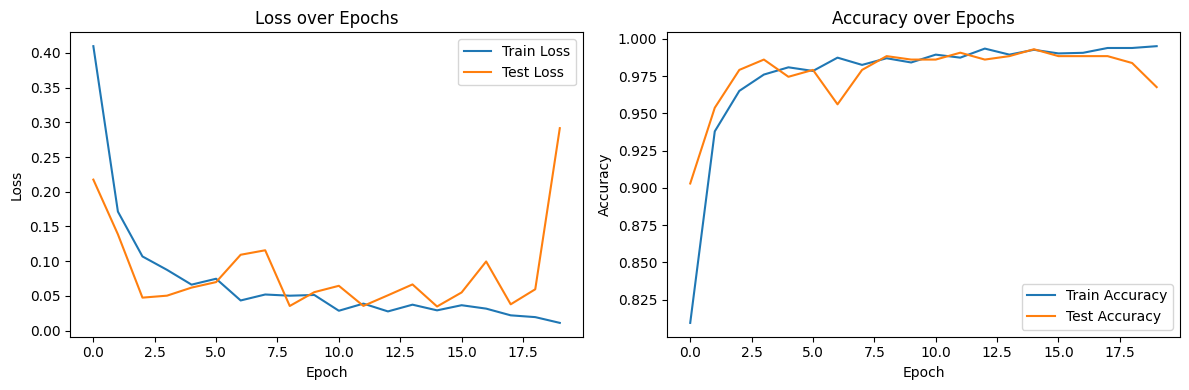

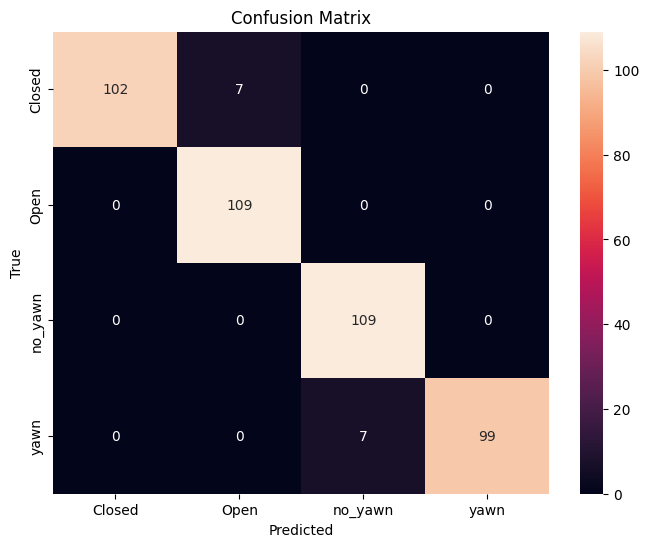

=== Đánh giá hiệu suất phân loại ===
Overall Accuracy: 0.9677

Chi tiết từng lớp:
Lớp Closed:
  Precision: 1.0000
  Recall: 0.9358
  F1-Score: 0.9668
  Support: 109 (số mẫu)

Lớp Open:
  Precision: 0.9397
  Recall: 1.0000
  F1-Score: 0.9689
  Support: 109 (số mẫu)

Lớp no_yawn:
  Precision: 0.9397
  Recall: 1.0000
  F1-Score: 0.9689
  Support: 109 (số mẫu)

Lớp yawn:
  Precision: 1.0000
  Recall: 0.9340
  F1-Score: 0.9659
  Support: 106 (số mẫu)

Trung bình (Macro Average):
  Precision: 0.9698
  Recall: 0.9674
  F1-Score: 0.9676


In [8]:
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Tính toán ma trận nhầm lẫn
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Tính Precision, Recall, F1-Score cho từng lớp
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)

# Tính độ chính xác tổng thể (Overall Accuracy)
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm)

# Hiển thị kết quả
print("=== Đánh giá hiệu suất phân loại ===")
print(f"Overall Accuracy: {overall_accuracy:.4f}\n")

print("Chi tiết từng lớp:")
for i, class_name in enumerate(class_names):
    print(f"Lớp {class_name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1[i]:.4f}")
    print(f"  Support: {support[i]} (số mẫu)\n")

# Tính các chỉ số trung bình (macro average)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
print("Trung bình (Macro Average):")
print(f"  Precision: {precision_macro:.4f}")
print(f"  Recall: {recall_macro:.4f}")
print(f"  F1-Score: {f1_macro:.4f}")

### 5. Kết luận
- Mô hình VGG16 đã được huấn luyện thành công trên dataset Yawn Eye.
- Các biểu đồ loss/accuracy và ma trận nhầm lẫn cho thấy hiệu suất của mô hình.
- Có thể cải thiện thêm bằng cách: tăng số epoch, điều chỉnh learning rate, hoặc sử dụng kỹ thuật data augmentation mạnh hơn.

### 6. Kiểm tra mô hình
- Tải lại mô hình tốt nhất đã lưu.
- Dự đoán trên tập test và hiển thị một số ví dụ kết quả (ảnh + nhãn thực tế + nhãn dự đoán).

Testing the best model on test data:


<ipython-input-9-4a05af45b198>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))


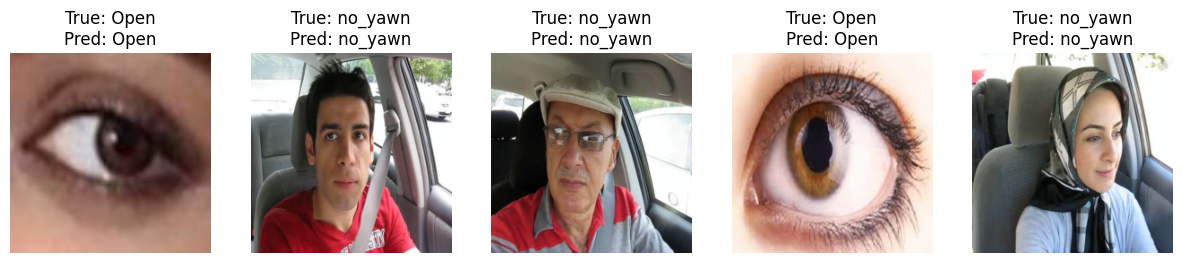

In [9]:
# Hàm kiểm tra mô hình
def test_model(model, dataloader, num_images=5):
    model.eval()
    images_shown = 0
    
    # Tải mô hình tốt nhất
    model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
    model.to(device)
    
    plt.figure(figsize=(15, 5))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Hiển thị một số ảnh cùng với nhãn
            for j in range(inputs.size()[0]):
                if images_shown >= num_images:
                    break
                images_shown += 1
                
                ax = plt.subplot(1, num_images, images_shown)
                ax.axis('off')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
            
            if images_shown >= num_images:
                break
    
    plt.show()

# Kiểm tra mô hình
print("Testing the best model on test data:")
test_model(model, dataloaders, num_images=5)